## Advanced Lane Finding

### Overview

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

- Apply a distortion correction to raw images.

- Use color transforms, gradients, etc., to create a thresholded binary image.

- Apply a perspective transform to rectify binary image ("birds-eye view").

- Detect lane pixels and fit to find the lane boundary.

- Determine the curvature of the lane and vehicle position with respect to center.

- Warp the detected lane boundaries back onto the original image.

- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Camera Calibration

In [2]:
# Camera Calibration and Undistort
# Follows lesson guidelines -
#    Objp has some constant points like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) and is the same for all calibartion images
#    Find the corners in each image
#      If corners are found, use the objp and corners for camera calibration.
#     Some images may not have 9x6 corners.

def Calibrate_Camera():
    # Use the camera calibration images
    
    image_files = glob.glob('./camera_cal/calibration*.jpg')
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    objpoints = []  # 3D
    imgpoints = []  # 2D
    images = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Read in images

    for fname in image_files :
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if (ret) :
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        images.append(img)    

    #Calibrate the Camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def undistort_image(image) :
    # Distortion Correction
    return cv2.undistort(image, mtx, dist, None, mtx)

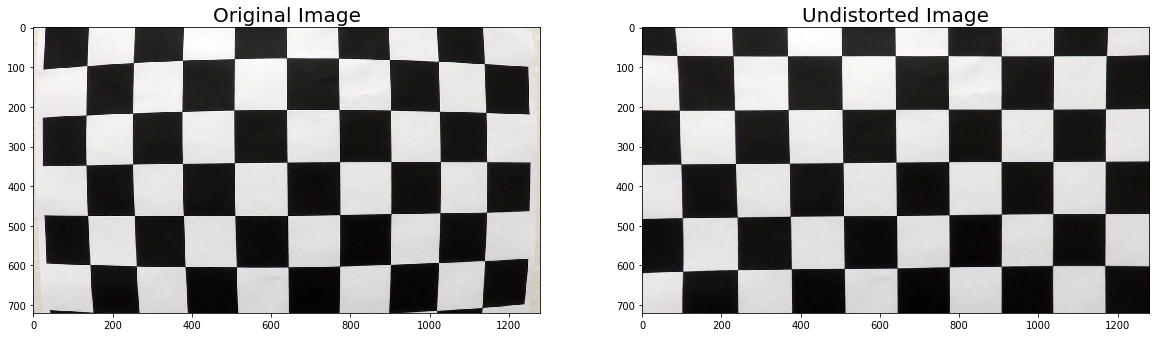

In [3]:
## Camera Calibration Done here for the entire pipeline.

ret, mtx, dist, rvecs, tvecs = Calibrate_Camera()

image = mpimg.imread('./camera_cal/calibration1.jpg')
# Distortion Correction
undist_image = undistort_image(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.2)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

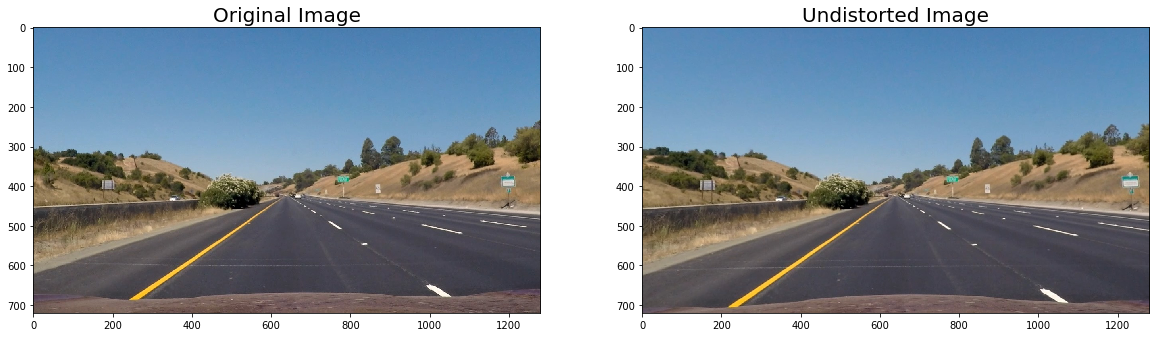

In [4]:
# Visualize one of the test images for undistort
image = mpimg.imread('./test_images/straight_lines1.jpg')
# Distortion Correction
undist_image = undistort_image(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.2)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

### Threshold functions

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >=thresh[0]) & (grad_dir <=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    grad = np.sqrt(gradx**2 + grady**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad = np.uint8(255 * (grad/np.max(grad)))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= mag_thresh[0]) & (grad <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output

# Input is a color(RGB) image
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <=thresh[1])] = 1
    return binary_output

In [6]:
# Various Image analysis functions
def display_RGB(rgb_img) :
    
    R = rgb_img[:,:,0]
    G = rgb_img[:,:,1]
    B = rgb_img[:,:,2]
    
    f, axes = plt.subplots(2, 2, figsize=(32, 12))
    f.tight_layout()
    axes[0,0].imshow(rgb_img)
    axes[0,0].set_title('Original Image', fontsize=25)
    axes[0,1].imshow(R, cmap='gray')
    axes[0,1].set_title('R Channel', fontsize=25)

    axes[1,0].imshow(G, cmap='gray')
    axes[1,0].set_title('G Channel', fontsize=25)
    axes[1,1].imshow(B, cmap='gray')
    axes[1,1].set_title('B Channel', fontsize=25)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def display_HLS(rgb_img) :
    
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    H = hls_img[:,:,0]
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    
    f, axes = plt.subplots(2, 2, figsize=(32, 12))
    f.tight_layout()
    axes[0,0].imshow(rgb_img)
    axes[0,0].set_title('Original Image', fontsize=25)
    axes[0,1].imshow(H, cmap='gray')
    axes[0,1].set_title('H Channel', fontsize=25)
    axes[1,0].imshow(L, cmap='gray')
    axes[1,0].set_title('L Channel', fontsize=25)
    axes[1,1].imshow(S, cmap='gray')
    axes[1,1].set_title('S Channel', fontsize=25)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

def display_HSV(rgb_img) :
    
    hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    H = hls_img[:,:,0]
    S = hls_img[:,:,1]
    V = hls_img[:,:,2]
    
    f, axes = plt.subplots(2, 2, figsize=(32, 12))
    f.tight_layout()
    axes[0,0].imshow(rgb_img)
    axes[0,0].set_title('Original Image', fontsize=25)
    axes[0,1].imshow(H, cmap='gray')
    axes[0,1].set_title('H Channel', fontsize=25)
    axes[1,0].imshow(S, cmap='gray')
    axes[1,0].set_title('S Channel', fontsize=25)
    axes[1,1].imshow(V, cmap='gray')
    axes[1,1].set_title('V Channel', fontsize=25)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


### Perspective Transform

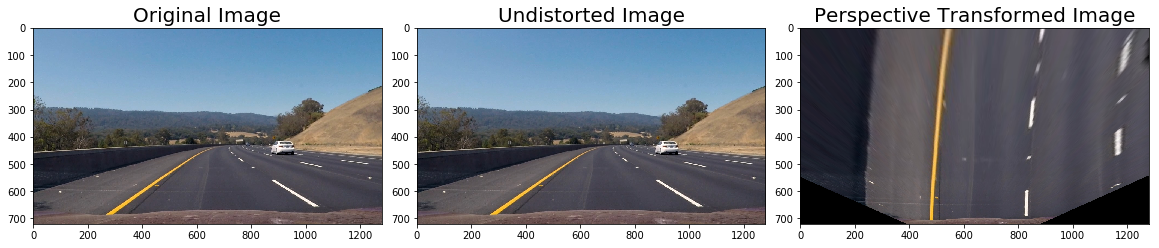

In [ ]:
#perspective transformation
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calculate_perspective_matrices():
    src = np.float32([[580,460],[710,460],[150,720], [1150,720]])    
    dst = np.float32([[450,0],[1280-450,0],[450,720],[1280-450,720]])

#     src = np.float32([[580,460],[710,460],[150,720], [1150,720]])    
#     dst = np.float32([[450,0],[1280-450,0],[450,720],[1280-450,720]])

    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    
    return M, M_inv
    
def perspective_transform(image) :
    return cv2.warpPerspective(image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)

# Visialize Perspective Transform.
M, M_inv = calculate_perspective_matrices()

# Sample Image
image = mpimg.imread('test_images/test3.jpg')
# Distortion Correction
undist_image = undistort_image(image)
# Perspective Transform on the undistorted image
persp_image = perspective_transform(image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.10)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)
ax3.imshow(persp_image, cmap='gray')
ax3.set_title('Perspective Transformed Image', fontsize=20)


In [ ]:
def explore_hls_select(thresh_min, thresh_max) :
    hls_binary = hls_select(image, thresh=(thresh_min, thresh_max))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('Hls Select', fontsize=20)
    plt.show()

#Read in an image and grayscale it
image = mpimg.imread('test_images/straight_lines1.jpg')
# Distortion Correction
image = undistort_image(image)
#Perspective Transform
image = perspective_transform(image)


interact (explore_hls_select, thresh_min=(0,255), thresh_max=(0,255))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [ ]:
def explore_sobel_thresh(ksize, threshx_min, threshx_max, threshy_min, threshy_max) :
        
    gradx = abs_sobel_thresh(sobel_image, orient='x', sobel_kernel=ksize, thresh=(threshx_min, threshx_max))
    grady = abs_sobel_thresh(sobel_image, orient='y', sobel_kernel=ksize, thresh=(threshy_min, threshy_max))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(gradx, cmap='gray')
    ax2.set_title('Thresh X', fontsize=20)
    ax3.imshow(grady, cmap='gray')
    ax3.set_title('Thresh Y', fontsize=20)

    plt.show()

#Read in an image and grayscale it
image = mpimg.imread('test_images/test5.jpg')
# Distortion Correction
image = undistort_image(image)
#Perspective Transform
image = perspective_transform(image)

sobel_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


interact (explore_sobel_thresh, ksize=(1,31,2), threshx_min=(0,255), threshx_max=(0,255), threshy_min=(0,255), threshy_max=(0,255) )

In [ ]:
def explore_mag_thresh(ksize, thresh_min, thresh_max) :
    
    mag_binary = mag_thresh(sobel_image, sobel_kernel=ksize, mag_thresh=(thresh_min, thresh_max))
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Mag Thresh', fontsize=20)

    plt.show()

#Read in an image and grayscale it
image = mpimg.imread('test_images/test4.jpg')
#Distortion Correction
image = undistort_image(image)
#Perspective Transform
image = perspective_transform(image)
sobel_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


interact (explore_mag_thresh, ksize=(1,31,2), thresh_min=(0,255), thresh_max=(0,255))

#21 96 210

In [ ]:
def explore_dir_thresh(ksize, thresh_min, thresh_max) :
    
    mag_binary = dir_threshold(sobel_image, sobel_kernel=ksize, thresh=(thresh_min, thresh_max))
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Dir Thresh', fontsize=20)

    plt.show()

#Read in an image and grayscale it
image = mpimg.imread('test_images/test3.jpg')
#Distortion Correction
image = undistort_image(image)
#Perspective Transform
image = perspective_transform(image)
sobel_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


interact (explore_dir_thresh, ksize=(1,31,2), thresh_min=(0,np.pi/2), thresh_max=(0,np.pi/2))

In [ ]:
# HLS thresh = (90, 255)
# Ksize=5, gradx_thresh (20, 160), grady_thresh=(140, 255)
# mag thresh: ksize=17, min=30 max=130
# dir Threshold: ksize=17, 0.9 - 1.1, 

In [ ]:
# Apply Various Thresholds determined with extensive experiments through the explore_* functions above.
# 
# return_type controls various display options. Details, Final, None
def apply_thresholds(image, return_type="None") :

    # Distortion Correction
    image = undistort_image(image)
    
    # Gaussian Blur
    kernel_size = 5
    image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    # Select s_image
    s_image     = hls_select(image, thresh=(170, 255))

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    ksize = 9
    # Various Sobel operations and thresholds
    gradx_image = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady_image = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_image = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_image = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
   
    magdir_image = np.zeros_like(dir_image)
    magdir_image[(mag_image == 1) & (dir_image == 1)] = 1
    
    sobel_xs = np.zeros_like(gradx_image)
    sobel_xs[(gradx_image == 1) | (s_image == 1)] = 1
    
    combined = np.zeros_like(dir_image)
    combined[((gradx_image == 1) & (grady_image == 1)) | ((mag_image == 1) & (dir_image == 1))] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    combined_image = np.zeros_like(combined)
    combined_image[(s_image > 0) | (combined > 0)] = 1
 

    vertices = np.array([[580,460],
                      [720,460],
                      [1200, 720],   
                      [150,720]])

    cropped_image = region_of_interest(combined_image, np.int32([vertices]))
    perspective_image = perspective_transform(cropped_image) 
    perspective_image[perspective_image > 0] = 1

    if (return_type == "Details") :
        f, axes = plt.subplots(5, 2, figsize=(20,30))
        f.subplots_adjust(hspace = .2, wspace=.05)
        axes[0,0].imshow(image)
        axes[0,0].set_title('Original Image', fontsize=20)
        axes[0,1].imshow(s_image, cmap='gray')
        axes[0,1].set_title('S Channel', fontsize=20)

        axes[1,0].imshow(gradx_image, cmap='gray')
        axes[1,0].set_title('Sobel GradX', fontsize=20)
        axes[1,1].imshow(grady_image, cmap='gray')
        axes[1,1].set_title('Sobel GradY', fontsize=20)

        axes[2,0].imshow(mag_image, cmap='gray')
        axes[2,0].set_title('Sobel Magnitude', fontsize=20)
        axes[2,1].imshow(dir_image, cmap='gray')
        axes[2,1].set_title('Sobel Direction', fontsize=20)

        axes[3,0].imshow(combined_image, cmap='gray')
        axes[3,0].set_title('Combined', fontsize=20)
        axes[3,1].imshow(sobel_xs, cmap='gray')
        axes[3,1].set_title('Sobel X& S-Channel', fontsize=20)

        axes[4,0].imshow(cropped_image, cmap='gray')
        axes[4,0].set_title('Cropped', fontsize=20)
        axes[4,1].imshow(perspective_image, cmap='gray')
        axes[4,1].set_title('Perspective', fontsize=20)
        outfile = "thresholds.jpg"
        f.savefig(outfile)
    elif (return_type == "Final") :
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
        f.subplots_adjust(hspace = .2, wspace=.05)
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cropped_image, cmap='gray')
        ax2.set_title('Cropped Final', fontsize=20)
        ax3.imshow(perspective_image, cmap='gray')
        ax3.set_title('Final Perspective', fontsize=20)
        plt.show()
    
    return perspective_image

image = mpimg.imread('test_images/test5.jpg')  
final_image = apply_thresholds(image, "Details")

image_files = glob.glob('./test_images/test*.jpg')
for file in image_files :
    image = mpimg.imread(file)    
    final_image = apply_thresholds(image, "Final")


### Lane Finding

In [ ]:

last_left_fit = []
last_right_fit = []

def find_lanes(binary_warped, margin=30, minpix=30) :
    global last_left_fit, last_right_fit 
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    rectangles = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Keep track of rectangles within each window
        rectangles.append(((win_xleft_low,win_y_low), (win_xleft_high,win_y_high)))
        rectangles.append(((win_xright_low,win_y_low),(win_xright_high,win_y_high)))

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if (len(left_lane_inds) > 800 ) :
        left_fit = np.polyfit(lefty, leftx, 2)
        last_left_fit = left_fit
    else :
        left_fit = last_left_fit
    
    if (len(right_lane_inds) > 800 ) :
        right_fit = np.polyfit(righty, rightx, 2)
        last_right_fit = right_fit
    else :
        right_fit = last_right_fit
   

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return rectangles, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

def draw_lanes(image, rectangles) :
    # Create an output image to draw on and potentially visualize the result
    binary_scaled = image*1
    display_img = np.dstack((binary_scaled, binary_scaled, binary_scaled))
    rect_color = (0, 0, 20)
    for r in range(int(len(rectangles))) :
        (corner1, corner2) =  rectangles[r]
        cv2.rectangle(display_img, corner1, corner2, rect_color, 2)    
    
    return display_img

def radius_of_curvature_and_center_distance(image, ploty, leftx, lefty, rightx, righty, left_fit, right_fit) :
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
#     xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
   
    car_position = image.shape[1]/2
    maxy = image.shape[0]
    left_fit_x = left_fit[0]*maxy**2 + left_fit[1]*maxy + left_fit[2]
    right_fit_x = right_fit[0]*maxy**2 + right_fit[1]*maxy + right_fit[2]
    lane_center = (right_fit_x + left_fit_x) /2
    center_dist = (car_position - lane_center) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist

In [ ]:
def project_path(input_image, out_img, leftx, lefty, rightx, righty, ploty, leftfitx, rightfitx, display) :
    # Create an image to draw on and an image to show the selection window

    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [1,0,0]
    out_img[righty, rightx] = [0,0,1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftfitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightfitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts_left]), (0,255, 100))
    cv2.fillPoly(window_img, np.int_([pts_right]), (0,255, 100))
    result = cv2.addWeighted(out_img, 0.7, window_img, 0.3, 0)

    projected_img = np.zeros_like(out_img).astype(np.uint8)
    cv2.fillPoly(projected_img, np.int_([pts]), (0, 255, 0))
    projected_img = cv2.warpPerspective(projected_img, M_inv, projected_img.shape[1::-1], flags=cv2.INTER_LINEAR)
    final_img = cv2.addWeighted(input_image, 1, projected_img, 0.3, 0)

    if (display == True) :
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
        f.subplots_adjust(hspace = .2, wspace=.05)
        ax1.imshow(result)
        ax1.set_title('Lanes ', fontsize=20)
        ax2.imshow(projected_img)
        ax2.set_title('Projected Path', fontsize=20)
        ax3.imshow(final_img)
        ax3.set_title('Path Overlaid', fontsize=20)
        ax1.plot(leftfitx, ploty, color='yellow')
        ax1.plot(rightfitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()

    return final_img



In [ ]:
def add_curvature_data(image, curv_rad, center_dist):
    # h = image.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(image, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_d = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_d) + 'm ' + direction + ' of center'
    cv2.putText(image, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return image

In [ ]:
margin = 30
minpix = 30
def process_image(image, display=False) :

    binary_warped = apply_thresholds(image, "None")
    
    rectangles, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = find_lanes(binary_warped, margin, minpix)
    
    out_img = draw_lanes(binary_warped, rectangles)
    
    final_img = project_path(image, out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx, display)
 
    leftr, rightr, centerd = radius_of_curvature_and_center_distance(final_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit)

    final_img = add_curvature_data(final_img, (leftr+rightr)/2, centerd)

    return final_img

In [ ]:

image_files = glob.glob('./test_images/*.jpg')
for file in image_files :
    image = mpimg.imread(file)    
    final = process_image(image, True)
    plt.title("Final Image", fontsize=20)
    plt.imshow(final)
    plt.show()

In [ ]:
from moviepy.editor import *

project_output = './project_video_output.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4")

clip1 = VideoFileClip("./project_video.mp4")

print("Read Video...")

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))